<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 3 / NOTE 4*

---

# Special Classification Problems

## 🏆 학습목표
1. 타겟 분포 불균형 문제의 특성을 이해하고 적절한 평가지표를 선택해 사용할 수 있다.
2. 타겟 분포 불균형 상태를 해결하기 위해 `class_weight`, `oversampling`, `undersampling` 방법을 사용할 수 있다.
3. (심화) 앙상블 기법을 활용해 타겟 불균형 분류 문제를 해결할 수 있다.

### Warm up

#### 다음 동영상을 시청하세요.
- [IAML2.22: Classification accuracy and imbalanced classes](https://www.youtube.com/watch?v=XeJZbCT84Js)
  - 왜 accuracy 만 사용하면 모델 성능에 대해 잘못된 판단을 내릴 수 있을까요?

### 📚 아래 라이브러리를 설치해 주세요.

#### 이번 모듈에서 추가적으로 사용하는 라이브러리는 다음과 같습니다. 설치를 확인해 주세요.
- [**imbalanced-learn**](https://imbalanced-learn.org/stable/#)

In [ ]:
!pip3 install imbalanced-learn
!pip install category_encoders
!pip3 install xgboost==1.7.2
!pip install scikit-learn==1.0 -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 3.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 4.9 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 17.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


# Classification with Extremely Imbalanced Target Distribution
- 지금까지 예시로 살펴본 분류 문제들은 대부분 타겟 분포의 불균형이 크게 심각하지 않은 경우들이었습니다.
- 하지만 현업에서는 매우 불균형한 타겟 분포를 갖는 분류 문제를 많이 마주하게 됩니다.
  - Fraud Detection 등의 문제에서는 실제 Fraud인 데이터들의 비율보다 정상 데이터의 비율이 압도적으로 많습니다(>99%)
  - 영화나 아이템을 추천하는 문제에서도, 굉장히 많은 non-clicked 아이템들과 극소수의 user-clicked 아이템으로 구성된 데이터로부터 분류 모델링을 실시하게 됩니다.
- 이렇게 타겟 분포가 굉장히 불균형한 상황에서는 전처리와 데이터 분석 등에 별도의 주의 사항이 요구됩니다.
- 또한 불균형 타겟 상황의 경우 대개 모델이 정상적으로 학습되지 않고 단일 예측값 등을 내는 이슈가 발생합니다. 이전 노트에서 배운 학습 테크닉들(`oversampling`, `undersampling`, `class_weight`)을 적용해 모델링을 진행하여야 합니다.
- 오늘은 타겟이 극도로 불균형한 분류 문제인 Case Study를 통해 타겟 불균형 상황에서의 여러 테크닉들을 살펴봅니다.


### 🚔 Case Study: Vehicle Insurance Claim Fraud Detection
- 교통사고에 대해 청구된 보험들 중 사기성 또는 과장된 청구를 분류하는 데이터셋입니다.

In [ ]:
import pandas as pd

df = pd.read_csv("https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/fraud_oracle.csv")
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [ ]:
df.columns  # 어떤 특성이 있나요?

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy'],
      dtype='object')

In [ ]:
print(df.shape)

(15420, 33)


In [ ]:
# 결측치를 확인해 봅시다. 결측치는 없군요.
df.isnull().sum()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64

In [ ]:
# 어떤 특성이 수치형인가요? 어떤 특성이 범주형인가요?
df.dtypes

Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Age                      int64
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P             int64
PolicyNumber             int64
RepNumber                int64
Deductible               int64
DriverRating             int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     int64
BasePoli

In [ ]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Month,15420,12,Jan,1411,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WeekOfMonth,15420.0,NaN,NaN,NaN,2.788586,1.287585,1.0,2.0,3.0,4.0,5.0
DayOfWeek,15420,7,Monday,2616,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Make,15420,19,Pontiac,3837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AccidentArea,15420,2,Urban,13822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeekClaimed,15420,8,Monday,3757,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthClaimed,15420,13,Jan,1446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WeekOfMonthClaimed,15420.0,NaN,NaN,NaN,2.693969,1.259115,1.0,2.0,3.0,4.0,5.0
Sex,15420,2,Male,13000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MaritalStatus,15420,4,Married,10625,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 몇몇 의미가 없는 Column들을 Drop합니다.

In [ ]:
df.nunique().sort_values(ascending=False)

PolicyNumber            15420
Age                        66
Make                       19
RepNumber                  16
MonthClaimed               13
Month                      12
AgeOfPolicyHolder           9
PolicyType                  9
DayOfWeekClaimed            8
AgeOfVehicle                8
DayOfWeek                   7
VehiclePrice                6
Days_Policy_Accident        5
NumberOfCars                5
AddressChange_Claim         5
WeekOfMonth                 5
WeekOfMonthClaimed          5
NumberOfSuppliments         4
PastNumberOfClaims          4
Days_Policy_Claim           4
DriverRating                4
Deductible                  4
MaritalStatus               4
VehicleCategory             3
Year                        3
BasePolicy                  3
FraudFound_P                2
Fault                       2
PoliceReportFiled           2
WitnessPresent              2
AgentType                   2
AccidentArea                2
Sex                         2
dtype: int

In [ ]:
# Policy는 Index와 동일한 의미를 가지므로 삭제합니다.
# Year 특성을 포함할 경우 미래 사건을 예측하기 어려워지므로 삭제합니다.
df = df.drop(columns=["PolicyNumber", "Year"])

In [ ]:
# Cardinailty를 보니 대부분의 특성이 범주형인 것 같습니다. corr 시각화 등 수치형에서 사용하는 분석법보다는 각 그룹별 평균 Fraud 등을 확인하는 것이 좋겠습니다.
df.nunique().sort_values(ascending=False)

Age                     66
Make                    19
RepNumber               16
MonthClaimed            13
Month                   12
PolicyType               9
AgeOfPolicyHolder        9
DayOfWeekClaimed         8
AgeOfVehicle             8
DayOfWeek                7
VehiclePrice             6
WeekOfMonth              5
Days_Policy_Accident     5
AddressChange_Claim      5
WeekOfMonthClaimed       5
NumberOfCars             5
DriverRating             4
Days_Policy_Claim        4
NumberOfSuppliments      4
Deductible               4
MaritalStatus            4
PastNumberOfClaims       4
BasePolicy               3
VehicleCategory          3
PoliceReportFiled        2
WitnessPresent           2
AgentType                2
Fault                    2
Sex                      2
AccidentArea             2
FraudFound_P             2
dtype: int64

### 타겟의 분포를 확인해 봅시다.
- 타겟 분포가 굉장히 불균형합니다. `Oversampling`, `Undersampling`, `class_weight` 등을 사용하여야 할 것 같습니다.

Baseline Accuracy: 0.9401426718547341


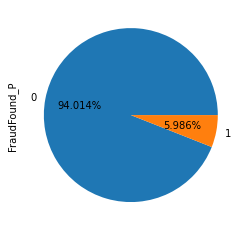

In [ ]:
target = "FraudFound_P"
df[target].value_counts(normalize=True).plot.pie(autopct="%.3f%%")
print("Baseline Accuracy:", df[target].value_counts(normalize=True).max())

### 타겟 클래스 비율이 불균형한 데이터로 모델링할 경우 발생하는 문제
- 소수 클래스에 대해서는 다양한 유형을 학습하지 못한다.
- 다수 클래스에 대해 치우친 학습이 수행되어 올바르게 예측하지 못하게된다.
- 따라서 학습을 위해 클래스의 균형을 이룰 수 있도록 충분히 데이터를 확보하는 방안이 필요하다.

### 학습 데이터와 평가 데이터의 분리
- 학습 데이터와 검증 / 평가 데이터의 분리는 반드시 `Oversampling`, `Undersampling` 등의 테크닉을 적용하기 이전에 진행되어야 합니다. 왜 그럴까요?
  - 검증 / 평가 데이터는 말 그대로 모델을 시범 운행해 봄으로써, 실제 상황에서 모델이 얼마나 데이터들을 잘 모델링하고 있는지를 확인하기 위한 목적입니다.
  - 따라서 평가용 데이터의 분포에 조작을 가하여 현실 세계의 데이터 분포와 멀어지게 된다면, 해당 데이터로부터 추출된 평가지표는 평가지표로서의 의미를 잃게 됩니다.
  - `Oversampling`, `Undersampling`은 불균형한 상황에서 모델이 잘 학습되지 않는 기술적 이슈를 해결하기 위한 테크닉일 뿐, 해당 테크닉이 모델 성능의 평가에 영향을 주어서는 안 됩니다.

In [ ]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, test_size=0.2, stratify=df[target], random_state=42)
print(train.shape, val.shape)

(12336, 31) (3084, 31)


In [ ]:
print("Train target distribution:\n", train[target].value_counts(normalize=True), "\n")
print("Val target distribution:\n", val[target].value_counts(normalize=True))

Train target distribution:
 0    0.940175
1    0.059825
Name: FraudFound_P, dtype: float64 

Val target distribution:
 0    0.940013
1    0.059987
Name: FraudFound_P, dtype: float64


- 검증 데이터가 전체 데이터와 유사한 타겟 비율을 갖도록 나눠졌습니다.

### GBDT 모델을 사용해 데이터를 모델링해 봅시다.

In [ ]:
X_train, y_train = train.drop(columns=[target]), train[target]
X_val, y_val = val.drop(columns=[target]), val[target]

In [ ]:
from category_encoders import OrdinalEncoder

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=987654321,
    random_state=42,
    n_jobs=-1,
    max_depth=5,
    learning_rate=0.1,
)
print(model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=987654321, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)


In [ ]:
watchlist = [(X_train_encoded, y_train), (X_val_encoded, y_val)]

model.fit(
    X_train_encoded,
    y_train,
    eval_set=watchlist,
    early_stopping_rounds=50,  # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

[0]	validation_0-auc:0.82236	validation_1-auc:0.81901
[1]	validation_0-auc:0.82870	validation_1-auc:0.82024
[2]	validation_0-auc:0.83006	validation_1-auc:0.82163
[3]	validation_0-auc:0.83012	validation_1-auc:0.82098
[4]	validation_0-auc:0.83101	validation_1-auc:0.82076
[5]	validation_0-auc:0.83371	validation_1-auc:0.82076


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-auc:0.83753	validation_1-auc:0.81310
[7]	validation_0-auc:0.83891	validation_1-auc:0.81997
[8]	validation_0-auc:0.83919	validation_1-auc:0.82481
[9]	validation_0-auc:0.84073	validation_1-auc:0.82336
[10]	validation_0-auc:0.84179	validation_1-auc:0.82250
[11]	validation_0-auc:0.84213	validation_1-auc:0.82223
[12]	validation_0-auc:0.84237	validation_1-auc:0.82302
[13]	validation_0-auc:0.84412	validation_1-auc:0.82179
[14]	validation_0-auc:0.84538	validation_1-auc:0.82191
[15]	validation_0-auc:0.84617	validation_1-auc:0.82359
[16]	validation_0-auc:0.84730	validation_1-auc:0.82143
[17]	validation_0-auc:0.84841	validation_1-auc:0.82136
[18]	validation_0-auc:0.84919	validation_1-auc:0.82160
[19]	validation_0-auc:0.84973	validation_1-auc:0.82192
[20]	validation_0-auc:0.85050	validation_1-auc:0.82090
[21]	validation_0-auc:0.85085	validation_1-auc:0.82082
[22]	validation_0-auc:0.85170	validation_1-auc:0.82123
[23]	validation_0-auc:0.85252	validation_1-auc:0.82058
[24]	validatio

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=987654321, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

### 학습된 모델의 검증 데이터셋에서의 결과를 확인해 보세요.
- 1-class의 Recall이 굉장히 낮습니다. 이 모델은 대부분의 입력을 0으로 예측하는 모델이라는 뜻입니다.

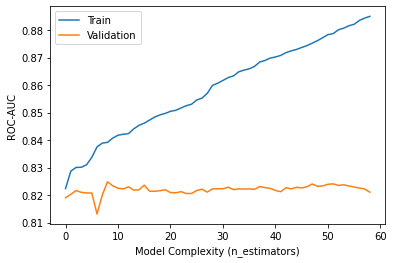

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

results = model.evals_result()
train_error = results["validation_0"]["auc"]
val_error = results["validation_1"]["auc"]

plt.plot(train_error, label="Train")
plt.plot(val_error, label="Validation")
plt.ylabel("ROC-AUC")
plt.xlabel("Model Complexity (n_estimators)")
plt.legend()

In [ ]:
from sklearn.metrics import classification_report

print("검증 정확도", model.score(X_val_encoded, y_val))

print(
    classification_report(
        y_val, model.predict(X_val_encoded, iteration_range=(0, model.best_iteration))
    )
)

검증 정확도 0.9409857328145266
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2899
           1       0.67      0.02      0.04       185

    accuracy                           0.94      3084
   macro avg       0.80      0.51      0.51      3084
weighted avg       0.92      0.94      0.91      3084



### 실제 모델의 예측 결과를 확인해 볼까요?
- 모델은 전체 3084개의 데이터 중 단 6개의 데이터에 대해서만 1이라고 대답했습니다.
- 모델은 현재 심각하게 0으로 편향되어 있는 상태라는 뜻입니다.

In [ ]:
model.predict(X_val_encoded, iteration_range=(0, model.best_iteration)).sum()

6

### ROC-AUC Score는 어떻게 나올까요?


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score


def get_roc_auc(model, X_val_encoded, y_val):
    if isinstance(model, XGBClassifier):
        y_pred_proba = model.predict_proba(
            X_val_encoded, iteration_range=(0, model.best_iteration)
        )[:, 1]
    else:
        y_pred_proba = model.predict_proba(X_val_encoded)[:, 1]

    print("ROC-AUC:", roc_auc_score(y_val, y_pred_proba))

    baseline_fpr, baseline_tpr, _ = roc_curve(y_val, [0] * len(y_val))
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    tmp = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds': thresholds})
    plt.plot(baseline_fpr, baseline_tpr, linestyle="--", color="green", label="Baseline"
    )
    plt.plot(fpr, tpr, color="blue", label="Model")
    plt.scatter(fpr, tpr, color="red")
    plt.legend()
    plt.title("ROC curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    return tmp

ROC-AUC: 0.8199668105497703


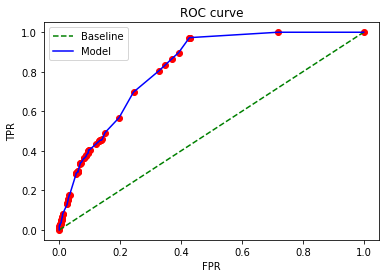

,fpr,tpr,thresholds
0,0.000000,0.000000,1.754428
1,0.000000,0.010811,0.754428
2,0.000000,0.021622,0.675852
3,0.001725,0.021622,0.429486
4,0.001725,0.027027,0.424519
...,...,...,...
62,0.427734,0.972973,0.261465
63,0.429458,0.972973,0.252179
64,0.430838,0.972973,0.238105
65,0.718524,1.000000,0.224491


In [ ]:
%matplotlib inline
get_roc_auc(model, X_val_encoded, y_val)

- 모델이 심각하게 편향된 예측을 함에도 불구하고 AUC Score도 굉장히 높게 나왔습니다!
- 이렇게 타겟 불균형이 존재할 때는 AUC가 실제 성능에 비해 높게 계산되어, 값 자체를 보고 성능을 가늠하는 것이 위험할 수 있습니다.
- 따라서, 타겟 불균형이 존재할 때는 confusion matrix를 직접 그려 보며 결과를 확인해야 합니다.

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def plot_confusion_matrix(model, X_val_encoded, y_val):
    if isinstance(model, XGBClassifier):
        y_pred = model.predict(X_val_encoded, iteration_range=(0, model.best_iteration))
    else:
        y_pred = model.predict(X_val_encoded)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='Blues')
    plt.show()

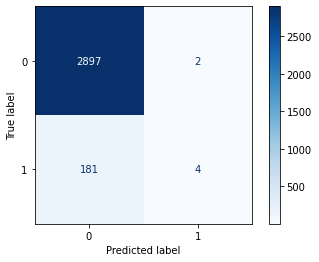

In [ ]:
plot_confusion_matrix(model, X_val_encoded, y_val)

### Class Weight를 사용해 모델을 재학습해 봅시다.
- `xgboost` 라이브러리에서는 `scale_pos_weight` 파라미터를 $ {NumNegSamples}/{NumPosSamples}$로 지정하여 두 클래스의 가중치를 균일하게 조정해 줄 수 있습니다.
  - 타겟 불균형 문제가 매우 심각할 때(일반적으로 > 99%)는 $ \sqrt{{NumNegSamples}/{NumPosSamples}}$로 지정하기도 합니다.
- sklearn의 모델에서는 `class_weight`를 `balanced`로 하여 가중치를 균일하게 맞춰줄 수 있습니다.

In [ ]:
import numpy as np
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=987654321,
    random_state=42,
    n_jobs=-1,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=(y_val == 0).sum() / (y_val == 1).sum(),   
    # 비율에 맞춰서 분리를 해줘서 크게 상관은 없지만 scale_pos_weight도 하이퍼파라미터니까 어떤 수치를 넣어주느냐도 다양한 방법이 적용될 것 같습니다!
)

watchlist = [(X_train_encoded, y_train), (X_val_encoded, y_val)]

model.fit(
    X_train_encoded,
    y_train,
    eval_set=watchlist,
    early_stopping_rounds=50,  # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

[0]	validation_0-auc:0.83433	validation_1-auc:0.81445
[1]	validation_0-auc:0.83916	validation_1-auc:0.82186
[2]	validation_0-auc:0.84068	validation_1-auc:0.82422
[3]	validation_0-auc:0.84369	validation_1-auc:0.82241
[4]	validation_0-auc:0.84471	validation_1-auc:0.82235
[5]	validation_0-auc:0.84642	validation_1-auc:0.82144


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-auc:0.84788	validation_1-auc:0.82101
[7]	validation_0-auc:0.84857	validation_1-auc:0.82012
[8]	validation_0-auc:0.84925	validation_1-auc:0.82103
[9]	validation_0-auc:0.85083	validation_1-auc:0.81990
[10]	validation_0-auc:0.85290	validation_1-auc:0.81946
[11]	validation_0-auc:0.85451	validation_1-auc:0.82083
[12]	validation_0-auc:0.85578	validation_1-auc:0.82052
[13]	validation_0-auc:0.85646	validation_1-auc:0.82183
[14]	validation_0-auc:0.85774	validation_1-auc:0.82076
[15]	validation_0-auc:0.85828	validation_1-auc:0.81955
[16]	validation_0-auc:0.86057	validation_1-auc:0.81873
[17]	validation_0-auc:0.86127	validation_1-auc:0.81997
[18]	validation_0-auc:0.86168	validation_1-auc:0.81973
[19]	validation_0-auc:0.86249	validation_1-auc:0.81822
[20]	validation_0-auc:0.86503	validation_1-auc:0.81775
[21]	validation_0-auc:0.86586	validation_1-auc:0.81743
[22]	validation_0-auc:0.86784	validation_1-auc:0.81712
[23]	validation_0-auc:0.86902	validation_1-auc:0.81705
[24]	validatio

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=987654321, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [ ]:
def summarize_results(model, X_val_encoded, y_val):
    # 1. Train / Val Loss Plot
    if isinstance(model, XGBClassifier):
        results = model.evals_result()
        tgts = results["validation_0"].keys()

        for tgt in tgts:
            train_error = results["validation_0"][tgt]
            val_error = results["validation_1"][tgt]

            plt.plot(train_error, label="Train")
            plt.plot(val_error, label="Validation")
            plt.ylabel(tgt)
            plt.xlabel("Model Complexity (n_estimators)")
            plt.legend()
            plt.show()

    # 2. Accuracy / Classification Report
    print("검증 정확도", model.score(X_val_encoded, y_val))

    if isinstance(model, XGBClassifier):
        y_pred = model.predict(X_val_encoded, iteration_range=(0, model.best_iteration))
    else:
        y_pred = model.predict(X_val_encoded)

    print(classification_report(y_val, y_pred))

    # 3. ROC-AUC
    get_roc_auc(model, X_val_encoded, y_val)

    # 4. Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(model, X_val_encoded, y_val,cmap='Blues')
    plt.show()

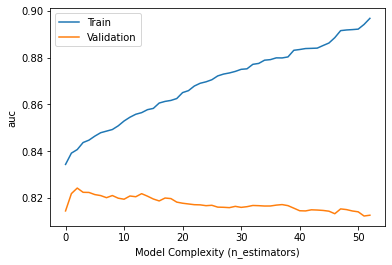

검증 정확도 0.6303501945525292
              precision    recall  f1-score   support

           0       0.99      0.62      0.76      2899
           1       0.13      0.88      0.22       185

    accuracy                           0.64      3084
   macro avg       0.56      0.75      0.49      3084
weighted avg       0.94      0.64      0.73      3084

ROC-AUC: 0.8218556258915003


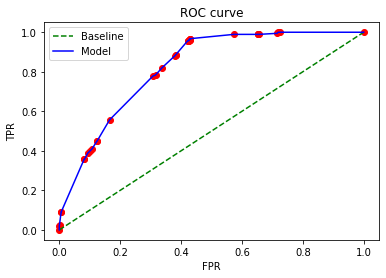

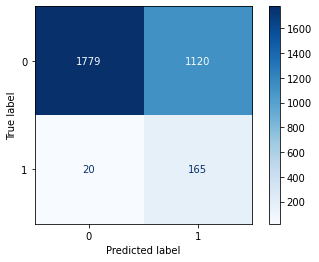

In [ ]:
summarize_results(model, X_val_encoded, y_val)

- 0-class에 대한 정확도를 다소 희생하였지만, 1-class의 정확도를 크게 향상시켰습니다.

### Undersampling
- `imblearn` 라이브러리의 undersampling 기능을 이용해 두 class의 샘플 수를 균일하게 맞춰준 후 학습을 진행하겠습니다.
- Undersampling은 두 클래스의 비율을 동일하게 맞춰 주는 강력한 방법이지만, 다수 클래스의 데이터에서 많은 손실이 발생한다는 단점이 있습니다.
- **NOTE) 검증 데이터셋에는 Undersampling이 적용되지 않아야 합니다!**

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=987654321,
    random_state=42,
    n_jobs=-1,
    max_depth=5,
    learning_rate=0.1,
)

X_train_sampled, y_train_sampled = RandomUnderSampler(random_state=42).fit_resample(
    X_train_encoded, y_train
)

In [ ]:
# Undersampling 시 각 class의 샘플들이 동일한 비율로 샘플링된 것을 볼 수 있습니다.
y_train_sampled.value_counts()

0    738
1    738
Name: FraudFound_P, dtype: int64

In [ ]:
watchlist = [(X_train_sampled, y_train_sampled), (X_val_encoded, y_val)]

model.fit(
    X_train_sampled,
    y_train_sampled,
    eval_set=watchlist,
    early_stopping_rounds=50,  # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

[0]	validation_0-auc:0.84146	validation_1-auc:0.80548
[1]	validation_0-auc:0.84545	validation_1-auc:0.80839
[2]	validation_0-auc:0.84752	validation_1-auc:0.81084
[3]	validation_0-auc:0.85192	validation_1-auc:0.81892
[4]	validation_0-auc:0.86051	validation_1-auc:0.81784
[5]	validation_0-auc:0.86292	validation_1-auc:0.81678
[6]	validation_0-auc:0.86505	validation_1-auc:0.81782
[7]	validation_0-auc:0.86654	validation_1-auc:0.81828
[8]	validation_0-auc:0.87012	validation_1-auc:0.81947
[9]	validation_0-auc:0.87476	validation_1-auc:0.82031
[10]	validation_0-auc:0.87498	validation_1-auc:0.81572
[11]	validation_0-auc:0.87692	validation_1-auc:0.81888
[12]	validation_0-auc:0.87932	validation_1-auc:0.82111
[13]	validation_0-auc:0.88421	validation_1-auc:0.81981
[14]	validation_0-auc:0.88594	validation_1-auc:0.82073
[15]	validation_0-auc:0.88724	validation_1-auc:0.82138
[16]	validation_0-auc:0.88994	validation_1-auc:0.82096
[17]	validation_0-auc:0.89065	validation_1-auc:0.82100
[18]	validation_0-au

/Users/boa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-auc:0.89498	validation_1-auc:0.81968
[20]	validation_0-auc:0.89953	validation_1-auc:0.82009
[21]	validation_0-auc:0.90187	validation_1-auc:0.82107
[22]	validation_0-auc:0.90501	validation_1-auc:0.82212
[23]	validation_0-auc:0.90705	validation_1-auc:0.82230
[24]	validation_0-auc:0.90898	validation_1-auc:0.82287
[25]	validation_0-auc:0.91200	validation_1-auc:0.82402
[26]	validation_0-auc:0.91450	validation_1-auc:0.82424
[27]	validation_0-auc:0.91787	validation_1-auc:0.82329
[28]	validation_0-auc:0.91982	validation_1-auc:0.82295
[29]	validation_0-auc:0.92054	validation_1-auc:0.82266
[30]	validation_0-auc:0.92170	validation_1-auc:0.82335
[31]	validation_0-auc:0.92362	validation_1-auc:0.82220
[32]	validation_0-auc:0.92561	validation_1-auc:0.82217
[33]	validation_0-auc:0.93053	validation_1-auc:0.82294
[34]	validation_0-auc:0.93411	validation_1-auc:0.82325
[35]	validation_0-auc:0.93567	validation_1-auc:0.82271
[36]	validation_0-auc:0.93624	validation_1-auc:0.82355
[37]	valid

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=987654321, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

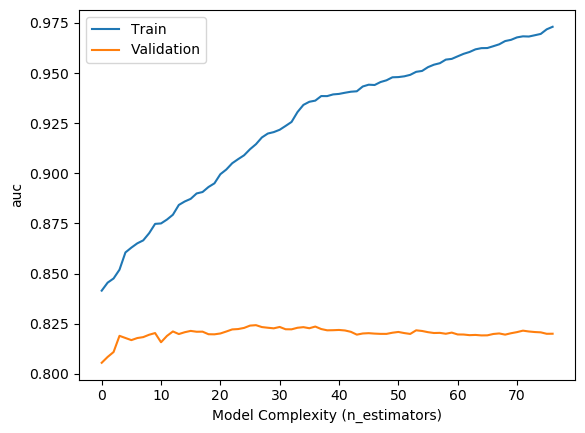

검증 정확도 0.6245136186770428
              precision    recall  f1-score   support

           0       0.99      0.60      0.75      2899
           1       0.13      0.95      0.23       185

    accuracy                           0.62      3084
   macro avg       0.56      0.77      0.49      3084
weighted avg       0.94      0.62      0.72      3084

ROC-AUC: 0.8240222630357159


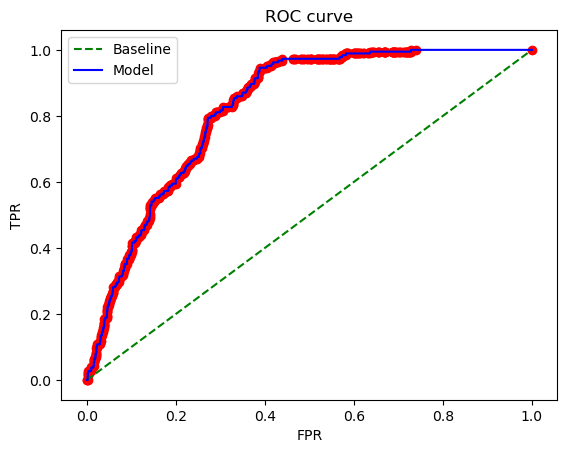

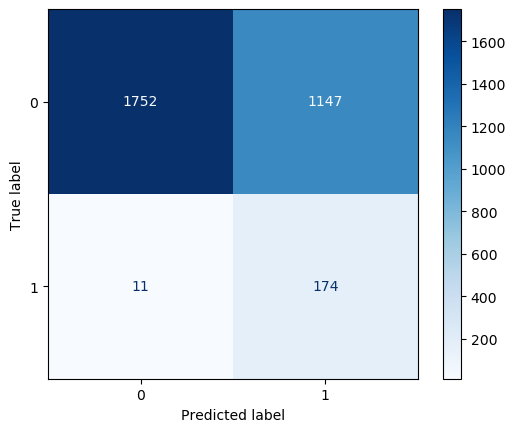

In [ ]:
summarize_results(model, X_val_encoded, y_val)

- 마찬가지로 0-class에 대한 정확도를 다소 희생하였지만 1-class에 대한 정확도를 향상시켰습니다.
- 불균형 문제가 심각할 때, `class_weight`를 사용함에도 학습이 잘 진행되지 않고 여전히 편향되거나 안정적이지 않은 예측 결과가 나오는 경우가 종종 있습니다.
- 이럴 때 `undersampling`은 `oversampling`에 비해 안정적이면서도 강력하게 두 class의 균형을 맞추어 주는 방법입니다.
- 하지만 학습에 사용된 데이터의 수가 크게 감소하므로, 학습 자체가 이루어지지 않거나 예상보다 낮은 성능 결과를 반환할 수 있습니다.

### Oversampling
- `imblearn` 라이브러리의 oversampling 기능을 이용해 보겠습니다.
- Oversampling은 소수 클래스의 기존 데이터들과 유사한 합성 데이터를 만들어서 데이터 수를 늘리는 방식입니다.
- **NOTE) 검증 데이터셋에는 Oversampling이 적용되지 않아야 합니다!**

In [ ]:
from imblearn.over_sampling import SMOTE


model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=987654321,
    random_state=42,
    n_jobs=-1,
    max_depth=5,
    learning_rate=0.1,
)

X_train_sampled, y_train_sampled = SMOTE(random_state=42).fit_resample(
    X_train_encoded, y_train
)

In [ ]:
# 1-class의 데이터가 0-class의 데이터 수만큼 늘어난 것을 볼 수 있습니다.
y_train_sampled.value_counts()

0    11598
1    11598
Name: FraudFound_P, dtype: int64

In [ ]:
watchlist = [(X_train_sampled, y_train_sampled), (X_val_encoded, y_val)]

model.fit(
    X_train_sampled,
    y_train_sampled,
    eval_set=watchlist,
    early_stopping_rounds=50,  # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

[0]	validation_0-auc:0.87761	validation_1-auc:0.77710
[1]	validation_0-auc:0.88557	validation_1-auc:0.77809
[2]	validation_0-auc:0.90162	validation_1-auc:0.77414
[3]	validation_0-auc:0.90342	validation_1-auc:0.77543
[4]	validation_0-auc:0.91713	validation_1-auc:0.77857
[5]	validation_0-auc:0.92188	validation_1-auc:0.77560
[6]	validation_0-auc:0.92162	validation_1-auc:0.77479
[7]	validation_0-auc:0.92384	validation_1-auc:0.77546
[8]	validation_0-auc:0.92558	validation_1-auc:0.77922


/Users/boa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-auc:0.92551	validation_1-auc:0.77763
[10]	validation_0-auc:0.92644	validation_1-auc:0.77625
[11]	validation_0-auc:0.92892	validation_1-auc:0.77819
[12]	validation_0-auc:0.93598	validation_1-auc:0.78047
[13]	validation_0-auc:0.93561	validation_1-auc:0.78045
[14]	validation_0-auc:0.93727	validation_1-auc:0.78002
[15]	validation_0-auc:0.93803	validation_1-auc:0.77772
[16]	validation_0-auc:0.93910	validation_1-auc:0.77881
[17]	validation_0-auc:0.94035	validation_1-auc:0.77938
[18]	validation_0-auc:0.94067	validation_1-auc:0.77858
[19]	validation_0-auc:0.94120	validation_1-auc:0.78018
[20]	validation_0-auc:0.94313	validation_1-auc:0.78051
[21]	validation_0-auc:0.94585	validation_1-auc:0.78138
[22]	validation_0-auc:0.94643	validation_1-auc:0.78251
[23]	validation_0-auc:0.94761	validation_1-auc:0.78421
[24]	validation_0-auc:0.94991	validation_1-auc:0.78475
[25]	validation_0-auc:0.95024	validation_1-auc:0.78443
[26]	validation_0-auc:0.95094	validation_1-auc:0.78417
[27]	valida

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=987654321, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

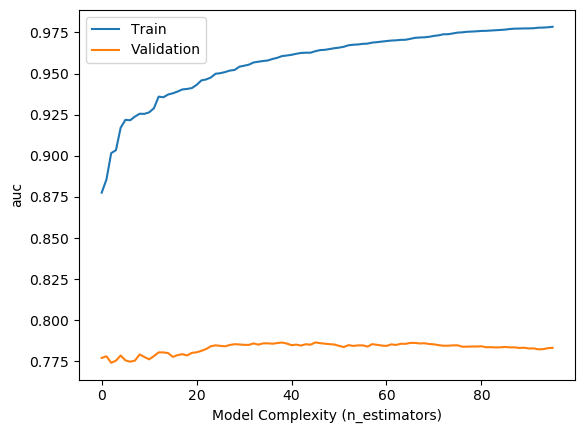

검증 정확도 0.8057717250324254
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      2899
           1       0.14      0.44      0.21       185

    accuracy                           0.81      3084
   macro avg       0.55      0.64      0.55      3084
weighted avg       0.91      0.81      0.85      3084

ROC-AUC: 0.7851104295050484


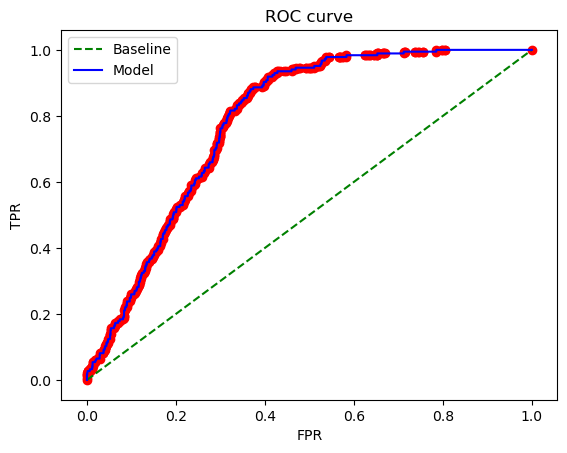

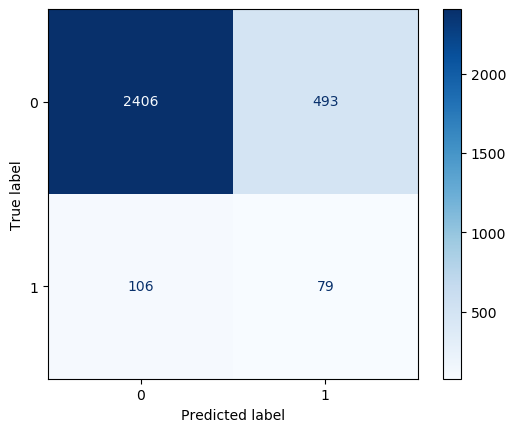

In [ ]:
summarize_results(model, X_val_encoded, y_val)

### Oversampling + Undersapmling
- Oversampling의 경우 기존 데이터를 기반으로 새로운 데이터를 합성하므로, 생성된 합성 데이터들이 noisy하다는 문제가 있습니다.
- 이를 해결하는 방법 중 하나로 새로운 데이터를 Oversampling으로 합성한 후, 생성된 데이터들 중 노이즈가 큰 데이터들을 Undersampling으로 정리하는 방법이 있습니다.
- `imblearn` 라이브러리에서는 `SMOTEENN`, `SMOTETomek` 등의 oversampling + undersampling combination 방법을 제공하고 있습니다.
- 자세한 설명은 [공식 문서](https://imbalanced-learn.org/stable/combine.html#)를 참고하세요.

In [ ]:
from imblearn.combine import SMOTEENN

X_train_sampled, y_train_sampled = SMOTEENN(random_state=42).fit_resample(
    X_train_encoded, y_train
)

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=987654321,
    random_state=42,
    n_jobs=-1,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=(y_train_sampled == 0).sum() / (y_train_sampled == 1).sum()
)

In [ ]:
# 0-class 데이터가 1-class 데이터만큼 생성되었다가 노이즈가 정리되었으므로, 결과적으로 각 타겟 데이터가 동일한 비율은 아니지만 0-class 데이터가 일부 새로 생성되었습니다.
y_train_sampled.value_counts()

1    11575
0     6777
Name: FraudFound_P, dtype: int64

In [ ]:
watchlist = [(X_train_sampled, y_train_sampled), (X_val_encoded, y_val)]

model.fit(
    X_train_sampled,
    y_train_sampled,
    eval_set=watchlist,
    early_stopping_rounds=50,  # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

[0]	validation_0-auc:0.89297	validation_1-auc:0.77613
[1]	validation_0-auc:0.89596	validation_1-auc:0.77168
[2]	validation_0-auc:0.91558	validation_1-auc:0.77248
[3]	validation_0-auc:0.92939	validation_1-auc:0.78054
[4]	validation_0-auc:0.92889	validation_1-auc:0.77755


/Users/boa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-auc:0.93317	validation_1-auc:0.77868
[6]	validation_0-auc:0.93550	validation_1-auc:0.77955
[7]	validation_0-auc:0.93503	validation_1-auc:0.77771
[8]	validation_0-auc:0.93637	validation_1-auc:0.77751
[9]	validation_0-auc:0.93772	validation_1-auc:0.77906
[10]	validation_0-auc:0.93752	validation_1-auc:0.77934
[11]	validation_0-auc:0.93956	validation_1-auc:0.77781
[12]	validation_0-auc:0.94063	validation_1-auc:0.77799
[13]	validation_0-auc:0.94456	validation_1-auc:0.77666
[14]	validation_0-auc:0.94454	validation_1-auc:0.77791
[15]	validation_0-auc:0.94601	validation_1-auc:0.77808
[16]	validation_0-auc:0.94853	validation_1-auc:0.77819
[17]	validation_0-auc:0.94935	validation_1-auc:0.77637
[18]	validation_0-auc:0.95066	validation_1-auc:0.77859
[19]	validation_0-auc:0.95167	validation_1-auc:0.77805
[20]	validation_0-auc:0.95512	validation_1-auc:0.78006
[21]	validation_0-auc:0.95589	validation_1-auc:0.77926
[22]	validation_0-auc:0.95753	validation_1-auc:0.77922
[23]	validation

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=987654321, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

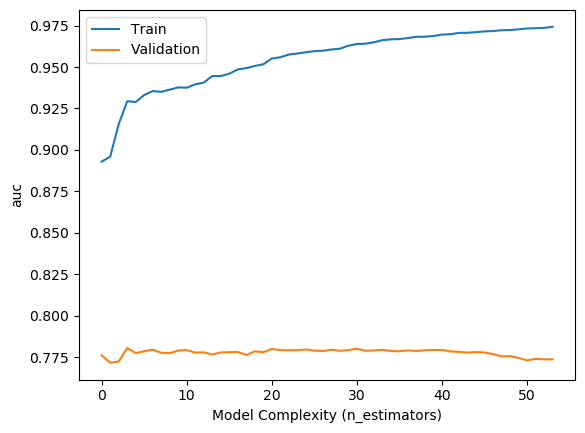

검증 정확도 0.7295719844357976
              precision    recall  f1-score   support

           0       0.97      0.73      0.83      2899
           1       0.13      0.62      0.21       185

    accuracy                           0.72      3084
   macro avg       0.55      0.67      0.52      3084
weighted avg       0.92      0.72      0.79      3084

ROC-AUC: 0.7724816572350205


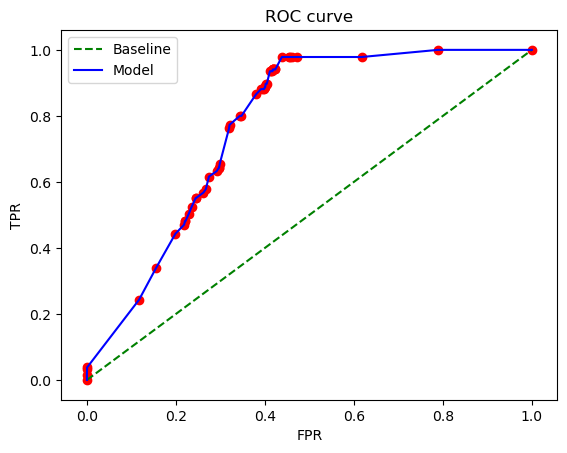

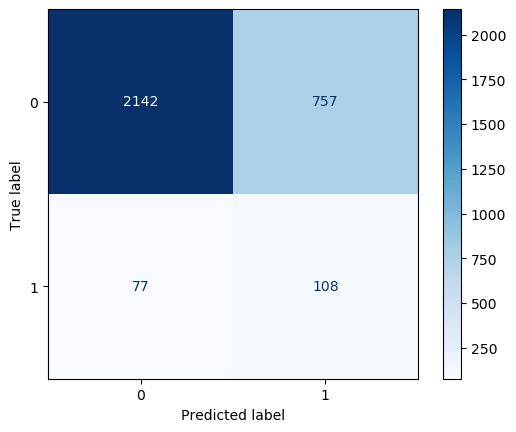

In [ ]:
summarize_results(model, X_val_encoded, y_val)

### Ensemble for Imbalanced Dataset
- 타겟 불균형 문제를 해결하기 위해 우리가 배운 앙상블 기법이 적용될 수도 있습니다.
- Undersampling과 Bagging을 함께 적용할 수 있습니다.
  - Undersampling은 다수 데이터의 큰 손실이 발생하는 문제가 있었습니다.
  - 여러 번 Undersampling을 수행하여 각 분류기를 만든 후, 분류기들의 결과를 평균낸다면 다수 데이터에서의 정보 손실을 줄일 수 있을 것입니다.
  - 이를 구현한 것이 `imblearn` 라이브러리의 `BalancedBaggingClassifier`입니다.
- 더 다양한 앙상블 기법에 대해서는 [공식 문서](https://imbalanced-learn.org/stable/ensemble.html)를 참고하세요.

In [ ]:
from imblearn.ensemble import BalancedBaggingClassifier

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=50,
    random_state=42,
    n_jobs=-1,
    max_depth=5,
    learning_rate=0.1,
)

bbc = BalancedBaggingClassifier(base_estimator=model, n_estimators=50, random_state=42)

In [ ]:
bbc.fit(X_train_encoded, y_train)

BalancedBaggingClassifier(base_estimator=XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric='auc',
                                                       feature_types=None,
                                                       gamma=None, gpu_id=None,
                                                       grow_policy=None,
                                                       importance_type=None,
          

검증 정확도 0.6222438391699092
              precision    recall  f1-score   support

           0       0.99      0.60      0.75      2899
           1       0.13      0.93      0.23       185

    accuracy                           0.62      3084
   macro avg       0.56      0.77      0.49      3084
weighted avg       0.94      0.62      0.72      3084

ROC-AUC: 0.8221343799819136


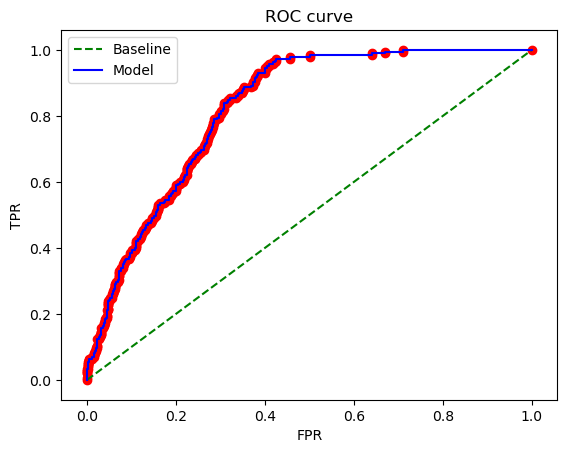

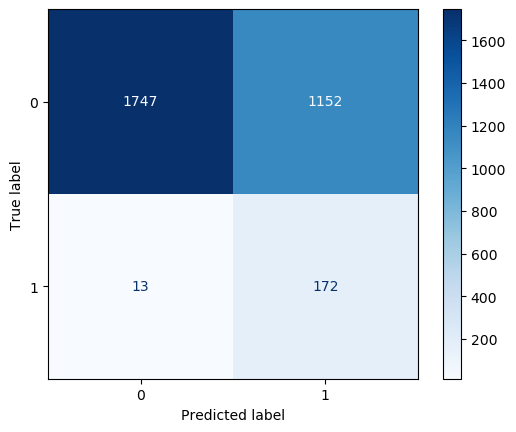

In [ ]:
summarize_results(bbc, X_val_encoded, y_val)

### Summary
- 기본적으로 불균형 타겟 분류 문제는 좋은 성능을 기대하기 어렵습니다.
- 하지만 불균형 타겟 상황에서 타겟의 비율을 맞춰주기 위한 여러 기법들을 사용할 수 있습니다.
  - `class_weight`, `undersampling`, `oversampling`의 세 가지 기법 중 하나를 성능에 따라 선택하여 사용하되, 성능을 고도화하기 위해 추가로 앙상블, combination 기법을 사용할 수 있습니다.
- 또한 불균형 타겟 분류 문제에서 성능을 확인하기 위해 `accuracy` 등을 단순히 사용하면 안 되며, `AUC` 또한 misleading한 값을 내놓을 수 있음도 확인했습니다.
  - 불균형 타겟 분류 문제를 해결할 때는 반드시 `confusion matrix`를 함께 확인하여, 상식적인 수준의 성능이 나오는지 확인해 보아야 합니다.

# References

- [imbalanced-learn](https://imbalanced-learn.org/stable/index.html)
- [xgboost api](https://xgboost.readthedocs.io/en/stable/python/python_api.html)
- 데이터가 뛰어노는 AI 놀이터, 캐글 상위 랭킹 진입을 위한 필살기 (가도와키 다이스케, 사카타 류지, 호사카 게이스케, 히라마쓰 유지 저/대니얼WJ )